# Implementing logistic regression on the FannieMae dataset

## Objective :

- Download Fanniemae data from http://www.fanniemae.com/portal/index.html
- Fannie Mae provides both an acquisitions file and a performance file for loans within its Single-Family Loan Performance Dataset. On a quarterly basis, the dataset is updated to add another quarter of acquisitions and another quarter of performance.
- Create user and use credentials to download the dataset for acquisitions and performance dataset for each desired quarter.
- After curating the data, implement imputation, and normalization.
- Identify default cases and set training data. Create model supervised classification using this training data and run the model on data set.
- Analyze the model output.

### Data Download and Pre-processing

In [1]:
import requests
from zipfile import ZipFile, BadZipFile
import io
import os
from itertools import product
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

USERNAME = "sam.trost@synechron.com"
PASSWORD = "P@ssw0rd"
LOGIN_URL = 'https://loanperformancedata.fanniemae.com/lppub/loginForm.html'
SAVE_DIR = 'FNMA_data'

col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']

col_per = ['LoanID','ReportingDate','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CurDelStatus','ModFlag','ZeroBalCode','ZeroBalEffDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','ForeclosureCost','RepairCost','AssetRecCost','MiscCostsPF',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OtherForePro','NonInterestUPB','PricipleForgiven','RMWPF',
          'FPWA','ServicingIndicator']

In [2]:
class fnma:
    def __init__(self, save_loc=None):
        if not save_loc:
            save_loc = os.getcwd()
        self.save_path = os.path.join(save_loc, SAVE_DIR)
        self.login_url = LOGIN_URL
        self.login_data = {
            'username': USERNAME,
            'password': PASSWORD
        }
        self.session = self.login_site()

    def login_site(self):
        client = requests.session()
        client.post(LOGIN_URL, data=self.login_data, headers={'Referrer': LOGIN_URL})
        return client

    def download_util(self, year, quarter):
        
        # Simple download and unzip utility, saves the two files in each .zip
        
        link = 'https://loanperformancedata.fanniemae.com/lppub/publish_aws?file={}Q{}.zip'.format(year, quarter)
        print('Downloading {}'.format(link))
        # Below is necessary as sometimes the link fails to return a zip file
        while True:
            try:
                zip_file = self.session.get(link)
                z = ZipFile(io.BytesIO(zip_file.content))
            except BadZipFile:
                continue
            break
        print("Unzipping {}".format(link))
        try:
            os.makedirs(self.save_path)
        except OSError:
            pass
        for file in z.infolist():
            with open(os.path.join(self.save_path, file.filename), mode='wb') as f:
                print("Saving {}".format(file.filename))
                for line in self.chunked(500000000, z.read(file.filename)):
                    f.write(line)
    
    @staticmethod
    def chunked(size, source):
        for i in range(0, len(source), size):
            yield source[i:i + size]
    
    def download_year(self, start, end=None):
        if not end:
            end = start + 1
        yq = product(range(start, end), range(1, 5))
        for dates in yq:
            self.download_util(year=dates[0], quarter=dates[1])
    
    def read_txt(self, kind, year, quarter):
        type_dict = {'a': 'Acquisition',
                     'p': 'Performance'}

        col_dict = {'a': col_acq,
                    'p': col_per}

        link = os.path.join(self.save_path, '{}_{}Q{}.txt'.format(type_dict[kind], year, quarter))

        chunk_s = 200000
        chunks = []

        reader = pd.read_csv(link, sep='|', chunksize=chunk_s, header=None, names=col_dict[kind])
        for chunk in reader:
            chunks.append(chunk)
            
        df = pd.concat(chunks, axis=0)
        del(chunks)
        
        return df
    
    def build_parquet(self, kind, year):
        
        # The Performance files are LARGE. Saving them as parquet instead of .txt makes them faster to open.
        
        type_dict = {'a': 'Acquisition',
                     'p': 'Performance'}
        link = os.path.join(a.save_path, 'FNMA_{}_{}.parquet'.format(type_dict[kind], year))
        writer = None
        for q in range(1, 5):
            table = pa.Table.from_pandas(a.read_txt(kind, year, q))
            if writer is None:
                writer = pq.ParquetWriter(link, table.schema)
            writer.write_table(table=table)
            del(table)
        writer.close()
        
    def get_full_year(self, year):
        
        # Does the joining and some transformations for the full year of data. Note: this does NOT currently
        # save the output of the function and instead only returns the dataframe. Make sure you save the output 
        # to a parquet with pq.write_table() unless you want to go through this slow process again!
        
        self.build_parquet('a', year)
        self.build_parquet('p', year)
        
        a_link = os.path.join(a.save_path, 'FNMA_Acquisition_{}.parquet'.format(year))
        p_link = os.path.join(a.save_path, 'FNMA_Performance_{}.parquet'.format(year))
        
        acq = pq.read_table(a_link, nthreads=7).to_pandas()
        per = pq.read_table(p_link, nthreads=7).to_pandas()
        
        ## ANY ADDITIONAL TRANSFORMATIONS GO BELOW THIS LINE
        # Currently only drops everything but the last row per LoanID in performance table and then joins on LoanID
        
        per.drop_duplicates(subset='LoanID', keep='last', inplace=True)
        df = pd.merge(acq, per, on='LoanID', how='inner')
        del(acq, per)
        
        return df


In [ ]:
YEAR = 2004
fnma = fnma()
fnma.download_year(2004)
df = fnma.get_full_year(2004)

### Set Imports 
- Dependencies for classifier models - from SK-Learn Package
- Dataframe dependecies - Pandas
- Data Visualization - seaborn and matplotlib
- ML Lifecycle - mlflow

In [1]:
import pandas as pd
import mlflow
import mlflow.sklearn
import io
import os
import seaborn as sns
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

### Feature Selection
In this section we are subsetting the key features that we need in our model from the merged dataframe.
For our prediction variable we consider that the foreclosure date as our default parameter.

In [12]:
df = df[['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm', 'OrDate',
    'FirstPayment','OrCLTV','NumBorrow','DTIRat','CreditScore',
    'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
    'Zip','RelMortInd','LoanAge','MonthsToMaturity','AdMonthsToMaturity','ForeclosureDate']]

Renaming the ForeclosureDate column to Default

In [13]:
df.rename(index=str, columns={"ForeclosureDate": 'Default'}, inplace=True)

### Target flag
In this we setting our target flag:
- 1 for a defaulter 
- 0 for a non-defaulter

In [14]:
df['Default'].fillna(0, inplace=True)
df.loc[df['Default'] != 0, 'Default'] = 1

df['Default'] = df['Default'].astype(int)

### Analyzing the target variable to check if we have an imbalanced dataset

In [15]:
df.groupby("Default").count()

,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrCLTV,NumBorrow,...,LoanPurpose,PropertyType,NumUnits,OccStatus,PropertyState,Zip,RelMortInd,LoanAge,MonthsToMaturity,AdMonthsToMaturity
Default,,,,,,,,,,,,,,,,,,,,,
0,441459,441459,441459,441459,441459,441459,441459,441459,441449,441452,...,441459,441459,441459,441459,441459,441459,441459,441459,441428,436366
1,11015,11015,11015,11015,11015,11015,11015,11015,11015,11015,...,11015,11015,11015,11015,11015,11015,11015,11015,11010,11015


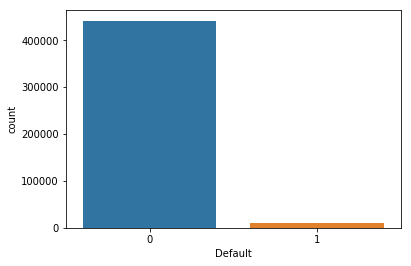

In [16]:
sns.countplot(df["Default"])

### Dropping the unncessary variables
These variables other than the LoanID can be used for further analysis if needed
- OrDate - OriginationDate of the loan
- FirstPayment - When the first payment for the loan was made
- Zip - Which state does the borrower live in

In [17]:
df.drop(['OrDate','FirstPayment','LoanID','Zip'], axis=1, inplace=True)

### Dealing with "Object" type variable
The getdummies function gives us dummy variables for all the categorical features in our dataset

In [18]:
def getdummies(df):
    columns = df.columns[df.isnull().any()]
    nan_cols = df[columns]

    df.drop(nan_cols.columns, axis=1, inplace=True)

    cat = df.select_dtypes(include=['object'])
    num = df.drop(cat.columns, axis=1)

    data = pd.DataFrame()
    for i in cat.columns:
        tmp = pd.get_dummies(cat[i], drop_first=True)
        data = pd.concat([data, tmp], axis=1)

    df = pd.concat([num,data,nan_cols], axis=1).reset_index(drop=True)
    return df

### Data Imputation
The fillnan function uses logistic regression for object type features and linear regression for numeric features to impute the null values.

In [19]:
def fillnan(df):
    columns = df.columns[df.isnull().any()]
    for name in columns:
        y = df.loc[df[name].notnull(), name].values
        X = df.loc[df[name].notnull()].drop(columns, axis=1).values
        X_test = df.loc[df[name].isnull()].drop(columns, axis=1).values
        if df[name].dtypes == 'object':
            model = LogisticRegression(random_state=0)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
        else:
            model = LinearRegression()
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
    return df

### Subsetting dataset below, please remove if necessary

In [20]:
df = df[1:100000]

### Using the static functions to rectify the data

In [21]:
df = getdummies(df)

In [22]:
df = fillnan(df)

### Rectifying the imbalanced dataset
- Instead of simply using under-sampling or over-sampling to rectify our imbalanced dataset we use SMOTE - A synthetic minority oversampling technique.
- This technique uses a synthetic approach to create new instances of the minor class instead of creating copies.
- The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

In [23]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN()

y = df['Default'].values
X = df.drop(['Default'], axis=1).values
X_resampled, y_resampled = sm.fit_sample(X, y)

## Data Processing
Splitting the data set into training and test and using that to make predictions.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=0)
with mlflow.start_run():    
    model = LogisticRegression(random_state = 0)
    model = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    precision = average_precision_score(y_test, predict)
    
    mlflow.log_metric("Precision Score", precision)
    mlflow.sklearn.log_model(model, "Logistic_Model")

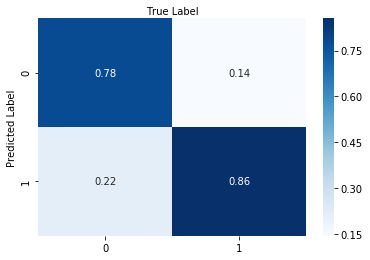

In [25]:
import matplotlib.pyplot as mp
%matplotlib inline

cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

### Cross validation
In this section we are using a three fold cross validation technique to validate our model

In [26]:
accuracies = cross_val_score(estimator = model, X = X_resampled, y = y_resampled, cv = 3)
accuracies.mean()

0.8233528180066475